# Importing libraries

In [3]:

from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations 
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import random
import json
import os
import zipfile
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img
import sys
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import EfficientNetB2
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.layers.pooling import GlobalAveragePooling2D
from tensorflow.keras.models import  load_model
from sklearn.model_selection import StratifiedKFold
import tensorflow_addons as tfa
from IPython.display import display
from keras.preprocessing import image

## Data loading

In [4]:
train_df = pd.read_csv("/home/ege/Desktop/kaggle/leaf/cassava-leaf-disease-classification/train.csv" )
Train_path = "/home/ege/Desktop/kaggle/leaf/cassava-leaf-disease-classification/train_images/"
Test_path = "/home/ege/Desktop/kaggle/leaf/cassava-leaf-disease-classification/test_images/"

## Data Exploration

In [5]:
number_of_train = len(os.listdir(Train_path ))
number_of_test = len(os.listdir(Test_path ))

In [6]:
print( "number of train images :  {}   number of test images : {} ".format(number_of_train ,number_of_test))

number of train images :  21397   number of test images : 1 


In [7]:
train_df.head()

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

In [8]:
with open('/home/ege/Desktop/kaggle/leaf/cassava-leaf-disease-classification/label_num_to_disease_map.json') as f:
  disease = json.load(f)


In [9]:
disease

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

## Data Visualization

<ipython-input-73-bfd339cea251>:3: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  plt.bar(x= disease_df.index , height= disease_df.values ,color= 'rgbmy', tick_label = ["Cassava Mosaic Disease",'Healthy','Cassava Green Mottle', 'Cassava Brown Streak Disease','Cassava Bacterial Blight'])


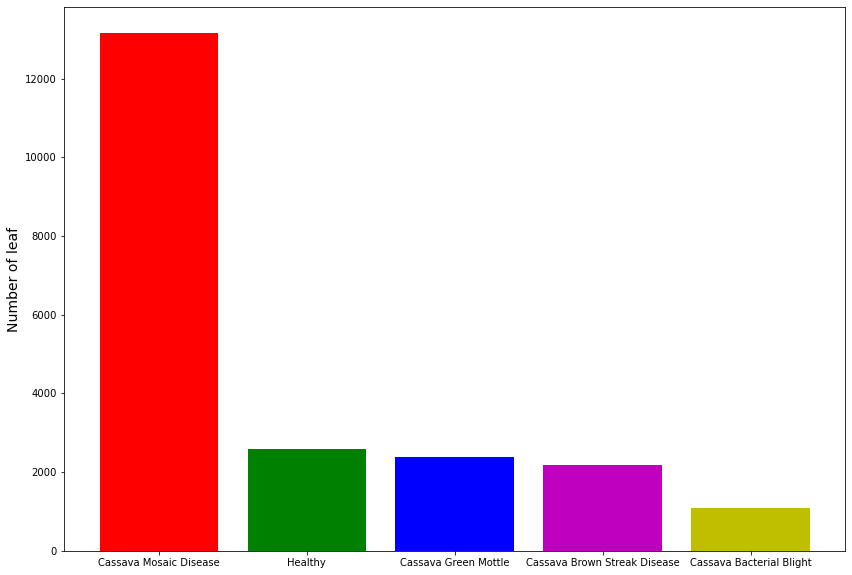

In [73]:
plt.subplots(figsize=(14,10))
disease_df =  train_df['label'].value_counts()
plt.bar(x= disease_df.index , height= disease_df.values ,color= 'rgbmy', tick_label = ["Cassava Mosaic Disease",'Healthy','Cassava Green Mottle', 'Cassava Brown Streak Disease','Cassava Bacterial Blight']) 
plt.ylabel("Number of leaf" , size = 14)

plt.show()

In [11]:
Bacterial_Blight  = train_df[train_df.label == 0 ] 
Brown_Streak_Disease =  train_df[train_df.label == 1  ]
Green_Mottle =  train_df[train_df.label == 2 ] 
Cassava_Mosaic_Disease = train_df[train_df.label == 3 ]
Healthy = train_df[train_df.label == 4]

In [12]:
pic_index = 4
pic_1 = [os.path.join( Train_path,name )  for name in Bacterial_Blight['image_id'][:pic_index] ]
pic_2 = [os.path.join( Train_path,name )  for name in Brown_Streak_Disease['image_id'][:pic_index] ]
pic_3 = [os.path.join( Train_path,name )  for name in Green_Mottle['image_id'][:pic_index] ]
pic_4 = [os.path.join( Train_path,name )  for name in Cassava_Mosaic_Disease['image_id'][:pic_index] ]
pic_5 = [os.path.join( Train_path,name )  for name in Healthy['image_id'][:pic_index] ]


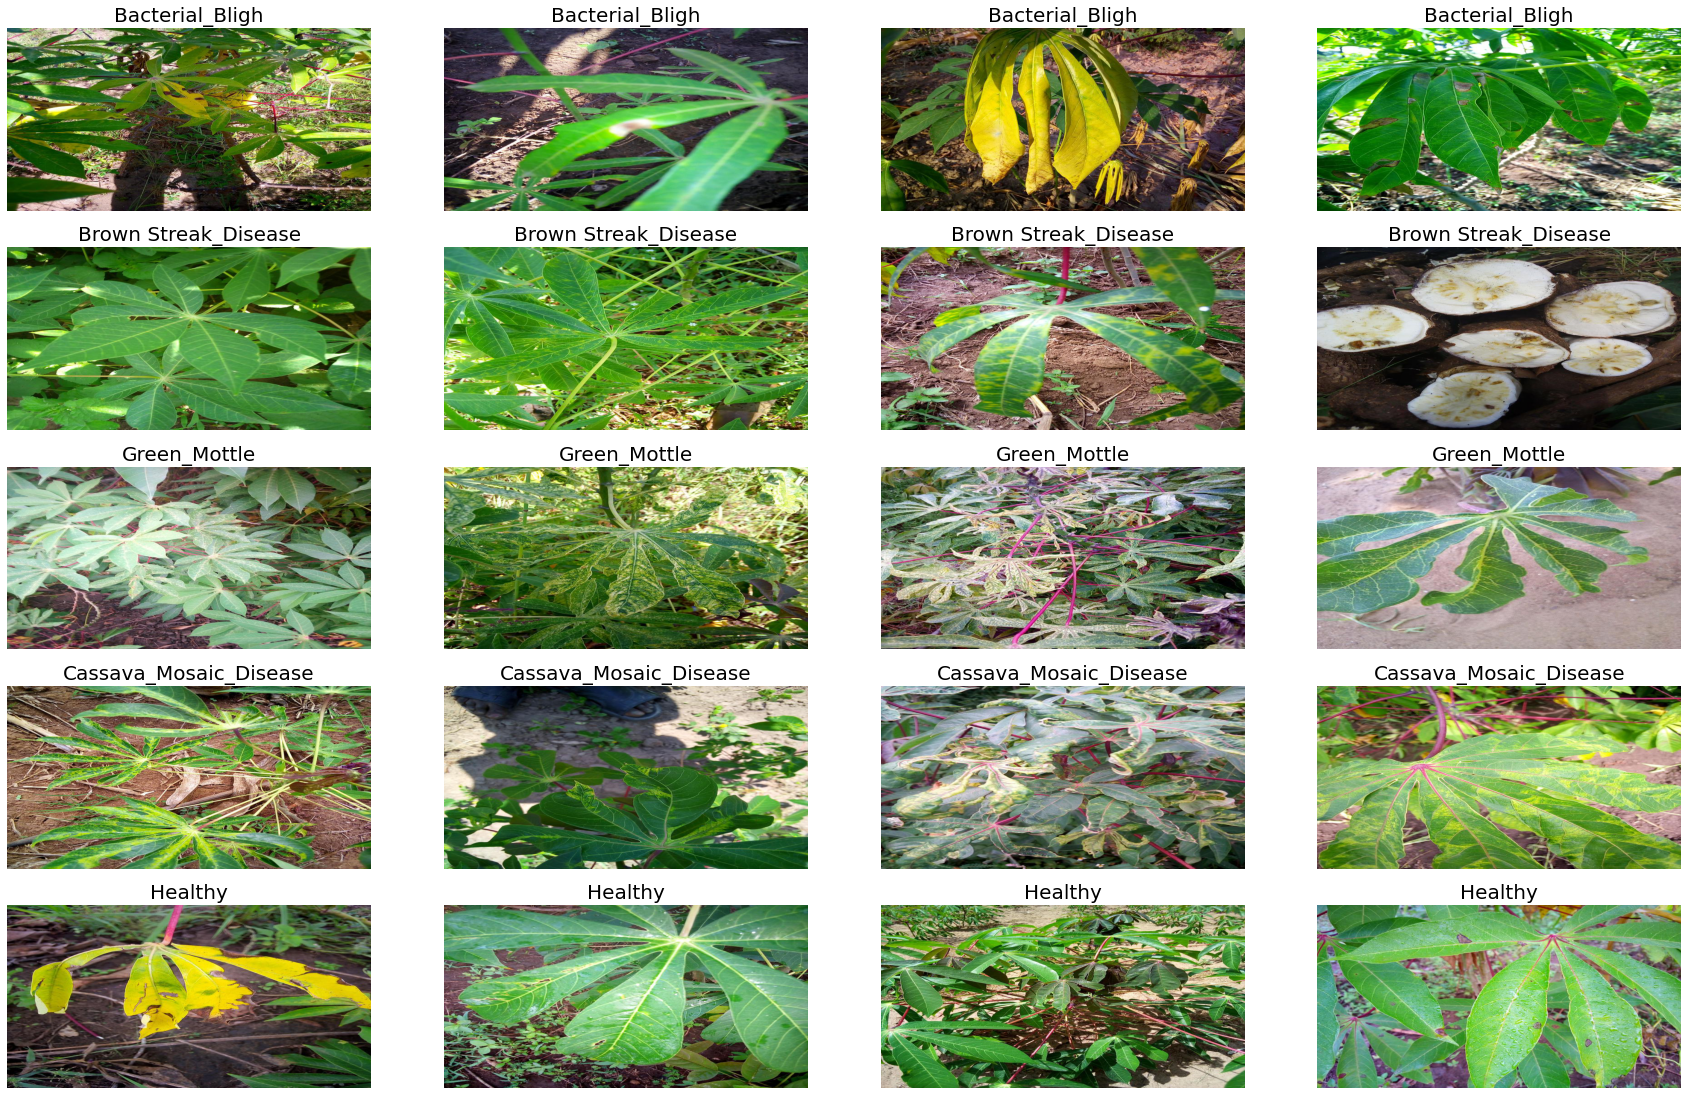

In [38]:

for num , img in enumerate(pic_1 + pic_2 + pic_3 + pic_4 + pic_5 ):
    sp = plt.subplot(20, 4, num + 1) 
    
    sp.axis('Off') 
    if   num  < 4:  
          plt.title('Bacterial_Bligh' , size = 20)
    elif num >=4 and num <8:
          plt.title('Brown Streak_Disease', size = 20)
    elif num>= 8 and num< 12: 
          plt.title("Green_Mottle" , size = 20)
            
    elif num >= 12 and num < 16: 
         plt.title("Cassava_Mosaic_Disease" , size = 20)
        
    else: 
        plt.title("Healthy" , size = 20)
    
    img = mpimg.imread(img)  
    plt.rcParams["figure.figsize"] = (30,70)
    plt.imshow(img ,aspect='auto' , cmap='gray')

plt.show()

## Data Preprocessing

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers

## Separating Data

In [15]:
train_df["label"] = train_df["label"].astype(str)
train_df['image_id'] =  Train_path + train_df['image_id'].values


In [16]:
Train , Test = train_test_split( train_df,  test_size=0.05, random_state=42)

In [17]:
Test.reset_index(drop=True, inplace=True)
Train.reset_index(drop=True, inplace=True)

In [162]:
print( "Train dataset shape : {}  // Test dataset shape : {}".format(Train.shape,Test.shape))

Train dataset shape : (20327, 2)  // Test dataset shape : (1070, 2)


## Image Augmentation 

In [18]:
def image_generator(train_dir , val_dir):
    
    train_datagen = ImageDataGenerator(  width_shift_range=0.15,
                                         height_shift_range=0.15,
                                         shear_range=0.1,
                                         rotation_range = 30,
                                         horizontal_flip=True,
                                         fill_mode='nearest')

    test_datagen  = ImageDataGenerator()
                                               
    train_generator = train_datagen.flow_from_dataframe(train_dir ,
                                                       x_col =  'image_id',
                                                       y_col = 'label',
                                                       target_size=(200, 180),
                                                       batch_size=32,
                                                       class_mode = "sparse" ,
                                                       shuffle = True,
                                                       seed=seed_value
                                                     )     


    test_generator =  test_datagen.flow_from_dataframe(val_dir,
                                                       x_col =  'image_id',
                                                       y_col = 'label',
                                                       target_size=(200, 180),
                                                       batch_size=32,
                                                       class_mode = "sparse" ,
                                                       shuffle = False,
                                                       seed=seed_value
                                               
                                                   )
    return train_generator , test_generator

## Model and Predictions

In [39]:
def create_model():
    
    #Define model
    model = tf.keras.models.Sequential() 
    # importin efficientnet
    model.add(EfficientNetB2(include_top=False, weights='imagenet' , input_shape= (200,180,3)))
    #addding layers
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(800, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(400, activation='relu'))
    model.add(tfa.layers.WeightNormalization(tf.keras.layers.Dense(200, activation='relu')))  
    model.add(tf.keras.layers.Dense(40, activation='relu'))
    model.add(tf.keras.layers.Dense(5, activation='softmax', dtype='float32'))
   

    #compiler
    model.compile(optimizer= 'adam', loss= "sparse_categorical_crossentropy", metrics = ['accuracy'])
    
    return model

In [40]:
tf.keras.backend.clear_session()
n_splits = 5   
seed_value = 42
acc_list = []
step = 0
epochs = 7
history_list = [[] , [] , [] ,[] , []]
skf = StratifiedKFold(n_splits= n_splits, random_state= seed_value , shuffle=True)

for train_index, val_index in skf.split(Train["image_id"], Train["label"]):
    
    train_dir = Train.loc[train_index]
    val_dir = Train.loc[val_index]
    
    train_datagen, val_datagen = image_generator( train_dir ,val_dir)
    model = create_model()
    print("number of step : " , step+1)
    model_name = "efnetb3"
    fold_name = "fold.h5"
    checkpoint_filepath = model_name + str(step+1) + fold_name

    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(filepath= checkpoint_filepath,  monitor='val_accuracy',  mode='max', save_best_only=True),  
    ]
                                       

    history = model.fit(train_datagen, epochs = epochs, validation_data = val_datagen,
                        steps_per_epoch= train_dir.shape[0]// 32 ,callbacks=callbacks)
    acc_list.append(max(history.history["val_accuracy"]))
   
    
     
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    history_list[step].append(acc)
    history_list[step].append(val_acc)
    history_list[step].append(loss)
    history_list[step].append(val_loss)
    step += 1    
    if  step == n_splits:
        print("Training finished!")
    

Found 16261 validated image filenames belonging to 5 classes.
Found 4066 validated image filenames belonging to 5 classes.
number of step :  1
Epoch 1/7
508/508 [==============================] - 176s 346ms/step - loss: 0.8123 - accuracy: 0.7031 - val_loss: 1.0756 - val_accuracy: 0.6040
Epoch 2/7
508/508 [==============================] - 174s 343ms/step - loss: 0.6821 - accuracy: 0.7637 - val_loss: 0.6798 - val_accuracy: 0.7673
Epoch 3/7
508/508 [==============================] - 172s 339ms/step - loss: 0.6381 - accuracy: 0.7801 - val_loss: 1.1940 - val_accuracy: 0.5711
Epoch 4/7
508/508 [==============================] - 173s 340ms/step - loss: 0.5968 - accuracy: 0.7912 - val_loss: 0.9114 - val_accuracy: 0.6963
Epoch 5/7
508/508 [==============================] - 173s 340ms/step - loss: 0.5640 - accuracy: 0.8036 - val_loss: 0.7508 - val_accuracy: 0.7395
Epoch 6/7
508/508 [==============================] - 174s 342ms/step - loss: 0.5367 - accuracy: 0.8145 - val_loss: 0.6087 - val_accu

## Examining ML Models 

In [193]:
step = 1
for acc in acc_list:
    print("{}. model training accuracy score : %{}".format(step, 100*acc))
    step +=1


1. model training accuracy score : %79.16871905326843
2. model training accuracy score : %79.83275651931763
3. model training accuracy score : %80.51660656929016
4. model training accuracy score : %82.18942284584045
5. model training accuracy score : %85.14145016670227


In [42]:
models_list = [] 
for _ in range(5):
    effnet = load_model("./efnetb3" + str(_+1) + "fold.h5")
    models_list.append(effnet)


## Model Graphs

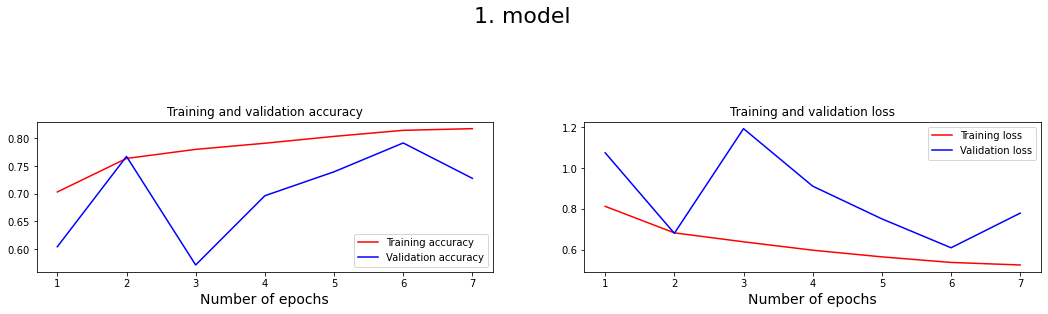

<Figure size 2160x5040 with 0 Axes>

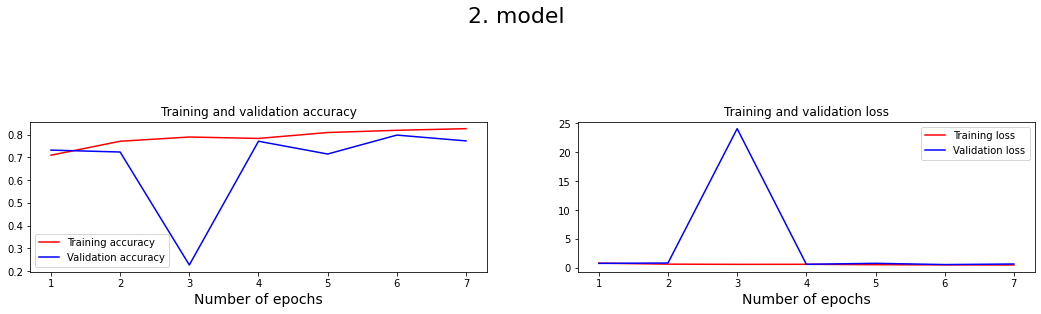

<Figure size 2160x5040 with 0 Axes>

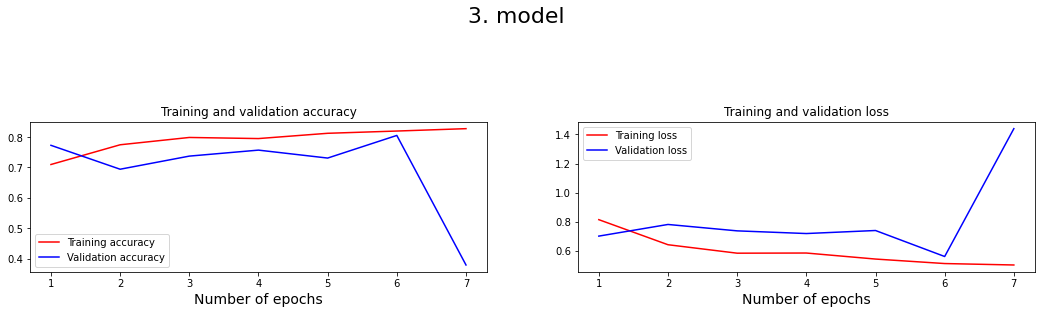

<Figure size 2160x5040 with 0 Axes>

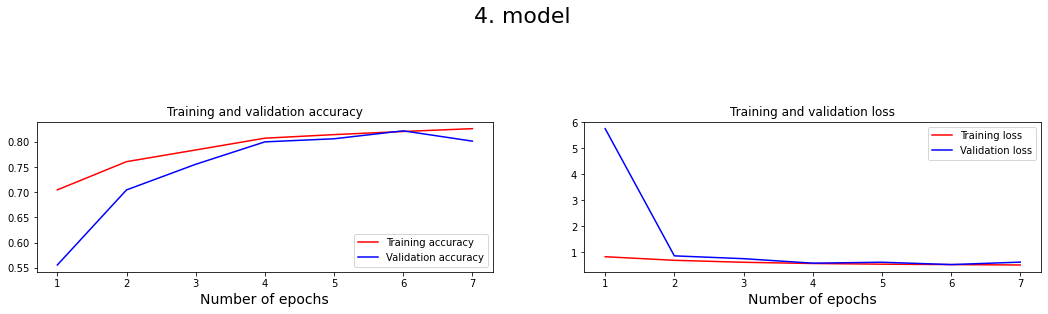

<Figure size 2160x5040 with 0 Axes>

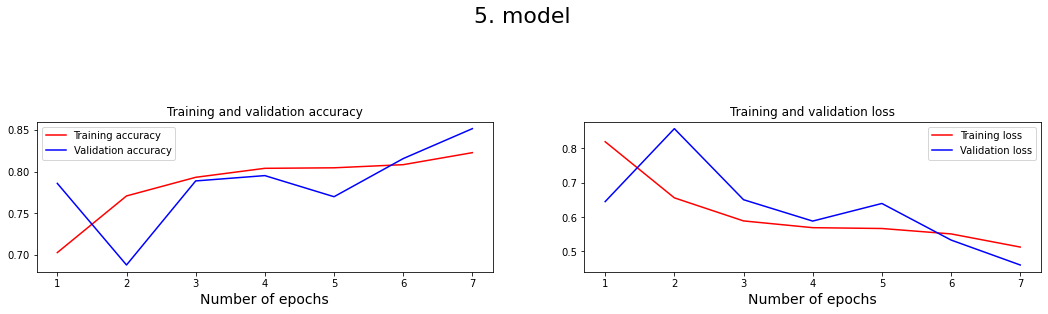

<Figure size 2160x5040 with 0 Axes>

In [44]:
model = 0 ; y = 1
while True:
    acc = history_list[model][0]
    val_acc = history_list[model][1]
    loss = history_list[model][2]
    val_loss = history_list[model][3]
    n_epochs = [ _ for _ in range(1,8)]

    plt.subplots(figsize=(18,16))
    plt.subplot(5, 2, y)
    plt.title('Training and validation accuracy')
    plt.xlabel("Number of epochs" , size = 14)
    
    plt.plot(n_epochs , acc, 'r', label='Training accuracy')
    plt.plot(n_epochs , val_acc, 'b', label='Validation accuracy')
    plt.legend(loc=0)

    plt.suptitle('{}. model'.format(model+1) , size = 22)
    plt.subplot(5, 2, y+1)
    plt.title('Training and validation loss')
    plt.xlabel("Number of epochs" , size = 14)
    plt.plot(n_epochs, loss, 'r', label='Training loss'   )
    plt.plot(n_epochs, val_loss, 'b', label='Validation loss' )
    plt.legend(loc=0)
    plt.figure()
    
    plt.show()
    model += 1
    if model == 5:
        break
    

## Adjusting Prediction Dataframe

In [59]:
n_model = 0 
predicted_list = [[], [] , [] , [] ,[]]
while True:
    selected_model = models_list[n_model]
    for fn in Test['image_id'].values.tolist():
        path =  fn
        img = image.load_img(path, target_size=(200, 180))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)

        images = np.vstack([x])
        predict = selected_model.predict(images, batch_size=10)
        predicted_list[n_model].append(predict) 
    n_model = n_model+1
    if   n_model == len(models_list):
        break


In [101]:
g = 0 ; a = 0 
final_predict_list = [[] ,[] ,[] ,[] ,[]]
while True:
    model_matrix = predicted_list[g]
    predicts_matrix = model_matrix[a]
    predict = np.argmax(predicts_matrix)
    final_predict_list[g].append(predict)
    a += 1
    if a == len(model_matrix):
        a = 0
        g += 1
    if g == len(predicted_list):
        break       
    

In [107]:
df_predict_1 = pd.DataFrame(data = final_predict_list[0], columns = ['predicts'])
df_predict_2 = pd.DataFrame(data = final_predict_list[1], columns = ['predicts'])
df_predict_3 = pd.DataFrame(data = final_predict_list[2], columns = ['predicts'])
df_predict_4 = pd.DataFrame(data = final_predict_list[3], columns = ['predicts'])
df_predict_5 = pd.DataFrame(data = final_predict_list[4], columns = ['predicts'])

## Examining Predictions 

In [163]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [127]:
cm1 = confusion_matrix(Test['label'].astype(int), df_predict_1['predicts'])
cm2 = confusion_matrix(Test['label'].astype(int), df_predict_2['predicts'])
cm3 = confusion_matrix(Test['label'].astype(int), df_predict_3['predicts'])
cm4 = confusion_matrix(Test['label'].astype(int), df_predict_4['predicts'])
cm5 = confusion_matrix(Test['label'].astype(int), df_predict_5['predicts'])

<ipython-input-150-68e9cd877c43>:3: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  plt.bar(x= disease_df.index , height= disease_df.values ,color= 'rgbmy', tick_label = ["Cassava Mosaic Disease",'Healthy','Cassava Green Mottle', 'Cassava Brown Streak','Cassava Bacterial Blight'])


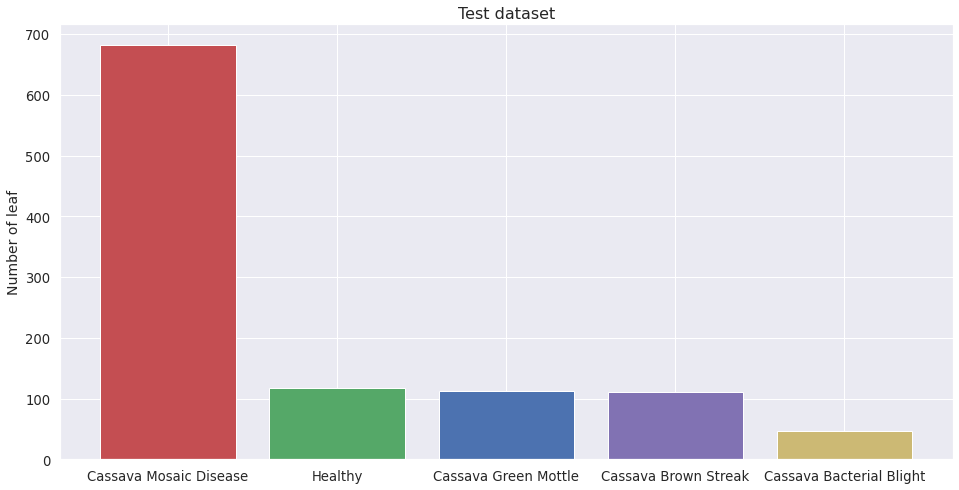

In [150]:
plt.subplots(figsize=(16,8))
disease_df =  Test['label'].value_counts()
plt.bar(x= disease_df.index , height= disease_df.values ,color= 'rgbmy', tick_label = ["Cassava Mosaic Disease",'Healthy','Cassava Green Mottle', 'Cassava Brown Streak','Cassava Bacterial Blight']) 
plt.ylabel("Number of leaf" , size = 14)
plt.title("Test dataset" , size = 16)
plt.show()

## Correlation Matrix of Predictions

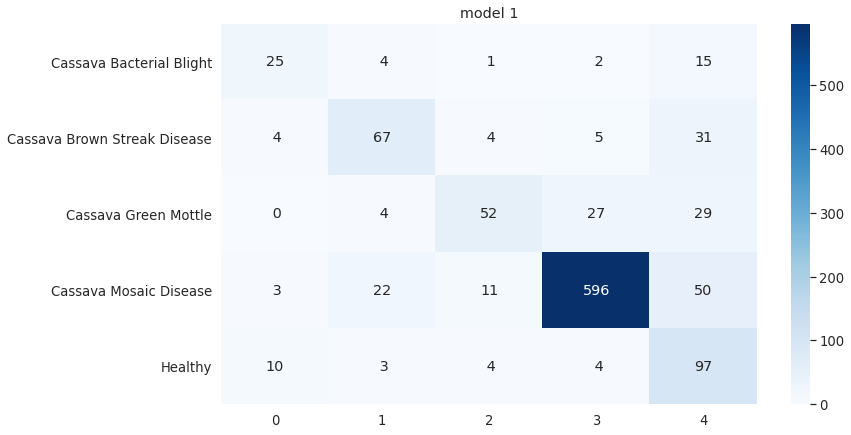

In [157]:
df_cm1 = pd.DataFrame(cm1, index = ["Cassava Bacterial Blight",'Cassava Brown Streak Disease','Cassava Green Mottle', 'Cassava Mosaic Disease','Healthy'])
plt.figure(figsize=(12,7))
sns.set(font_scale=1.2) 
sns.heatmap(df_cm1, annot=True , cmap='Blues', fmt='2g') 
plt.title("model 1")
plt.show()

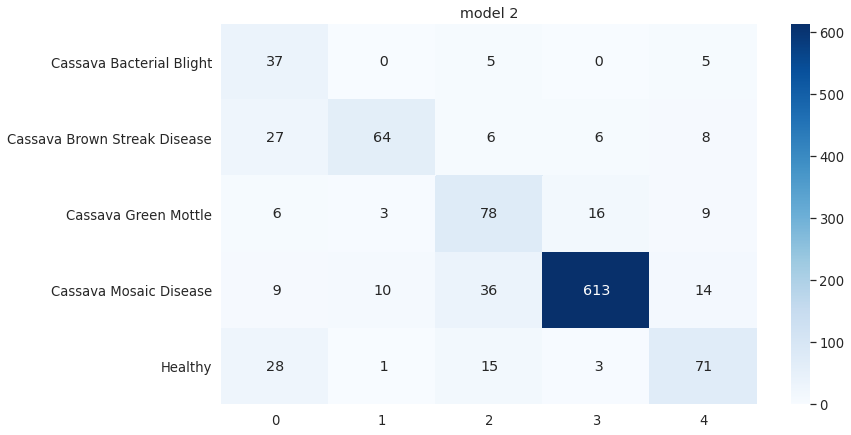

In [158]:
df_cm2 = pd.DataFrame(cm2, index = ["Cassava Bacterial Blight",'Cassava Brown Streak Disease','Cassava Green Mottle', 'Cassava Mosaic Disease','Healthy'])
plt.figure(figsize=(12,7))
sns.set(font_scale=1.2) 
sns.heatmap(df_cm2, annot=True ,  cmap='Blues', fmt='2g')
plt.title("model 2")
plt.show()

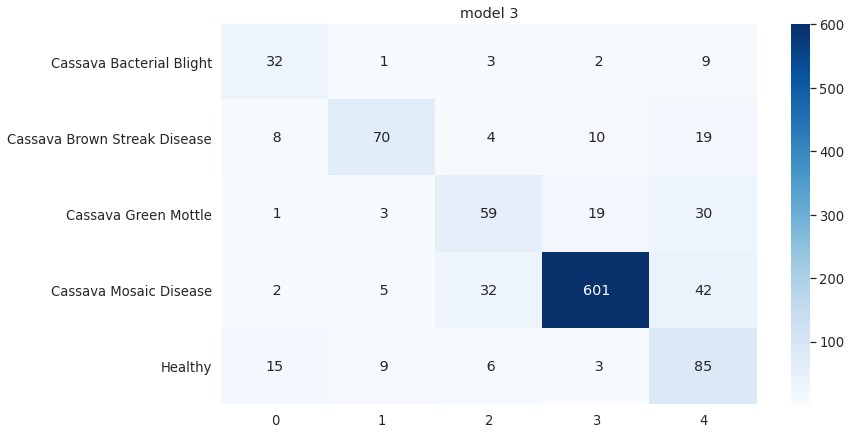

In [159]:
df_cm3 = pd.DataFrame(cm3, index = ["Cassava Bacterial Blight",'Cassava Brown Streak Disease','Cassava Green Mottle', 'Cassava Mosaic Disease','Healthy'])
plt.figure(figsize=(12,7))
sns.set(font_scale=1.2) 
sns.heatmap(df_cm3, annot=True ,  cmap='Blues', fmt='2g')
plt.title("model 3")
plt.show()

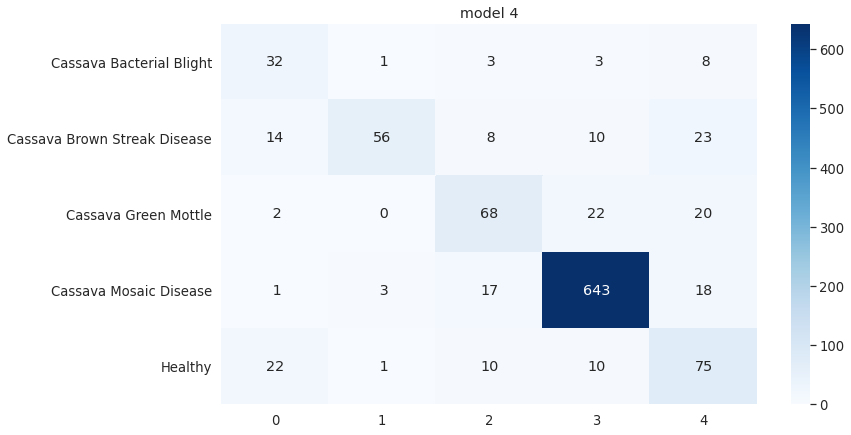

In [160]:
df_cm4 = pd.DataFrame(cm4, index = ["Cassava Bacterial Blight",'Cassava Brown Streak Disease','Cassava Green Mottle', 'Cassava Mosaic Disease','Healthy'])
plt.figure(figsize=(12,7))
sns.set(font_scale=1.2) # for label size
sns.heatmap(df_cm4, annot=True ,  cmap='Blues', fmt='2g') 
plt.title("model 4")
plt.show()

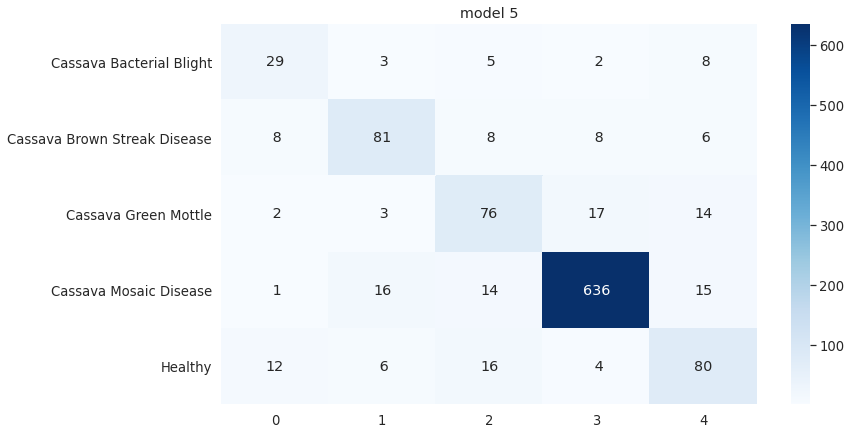

In [161]:
df_cm5 = pd.DataFrame(cm5, index = ["Cassava Bacterial Blight",'Cassava Brown Streak Disease','Cassava Green Mottle', 'Cassava Mosaic Disease','Healthy'])
plt.figure(figsize=(12,7))
sns.set(font_scale=1.2) # for label size
sns.heatmap(df_cm5, annot=True , cmap='Blues', fmt='2g')
plt.title("model 5")
plt.show()

In [167]:
ac1 = accuracy_score(Test['label'].astype(int), df_predict_1['predicts'])
ac2 = accuracy_score(Test['label'].astype(int), df_predict_2['predicts'])
ac3 = accuracy_score(Test['label'].astype(int), df_predict_3['predicts'])
ac4 = accuracy_score(Test['label'].astype(int), df_predict_4['predicts'])
ac5 = accuracy_score(Test['label'].astype(int), df_predict_5['predicts'])
score_df = pd.DataFrame(data = [ac1,ac2,ac3,ac4,ac5] , columns = ['acc_scores'])

## Accuracy Graph

In [177]:
columns = ["model 1", "model 2" , "model 3" , "model 4" , "model 5"]

<ipython-input-192-c1a2ef2020d5>:5: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  plt.barh(columns, score_df['acc_scores'].values.astype(float) , color = "rbmyg")


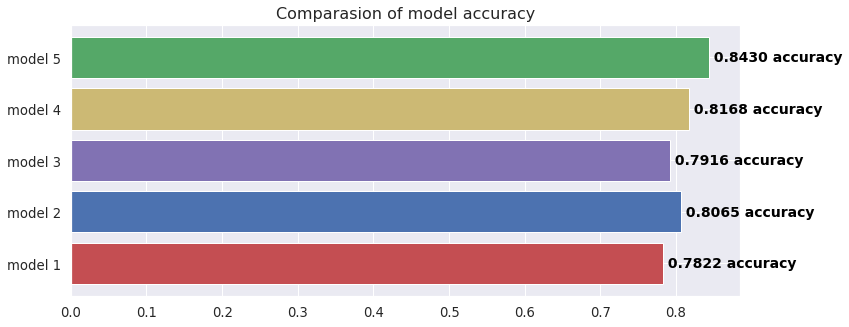

In [192]:

fig , ax = plt.subplots(figsize = (12,5))
for i, v in enumerate( score_df.values):
  ax.text(v, i, " "+str("%.4f" % v) + " accuracy", color='black', va='center', fontweight='bold',fontsize = 14)

plt.barh(columns, score_df['acc_scores'].values.astype(float) , color = "rbmyg") 


plt.title("Comparasion of model accuracy" , fontsize = 16 )
plt.show()